In [1]:
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh

%matplotlib inline

In [2]:
DATASET_NAME = 'ImageNet' 
ARCH = 'clip_RN50'
REWRITE_MODE = 'finetune_local'
LAYERNUM = 24
SYNTHETIC = True

## Load dataset and model

In [3]:
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 
model, context_model, target_model = ret[:3]

## Load base dataset and typographic attack imagess

In [4]:
preprocess = ret[-1]

base_dataset, _, _ = dh.get_dataset(DATASET_NAME, DATASET_PATH,
                                    batch_size=32, workers=8)
base_dataset.transform_test = preprocess
_, val_loader = base_dataset.make_loaders(workers=10, batch_size=50, shuffle_val=False)
targets = ch.tensor(val_loader.dataset.targets)

==> Preparing dataset imagenet..
==> Preparing dataset imagenet..


## Load typographic attacks

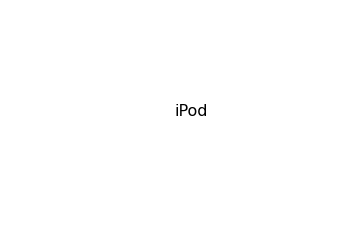

In [5]:
train_data, test_data = dh.get_typographic_attacks('./data/typographic', 
                                                   preprocess,
                                                   synthetic=SYNTHETIC)

Train data


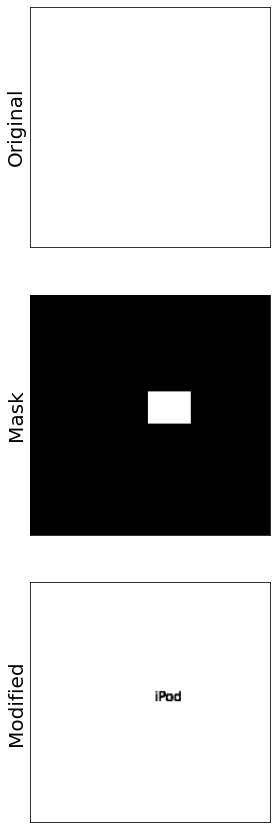

In [6]:
print("Train data")
vh.show_image_row([train_data['imgs'], train_data['masks'], train_data['modified_imgs']], 
                  ['Original', 'Mask', 'Modified'], fontsize=20,
                  size=(5, 5))

Typographic test set


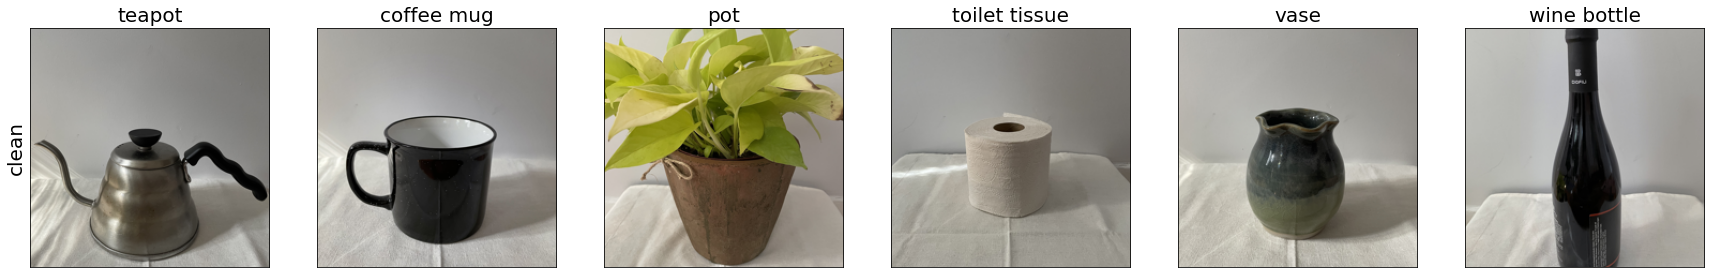

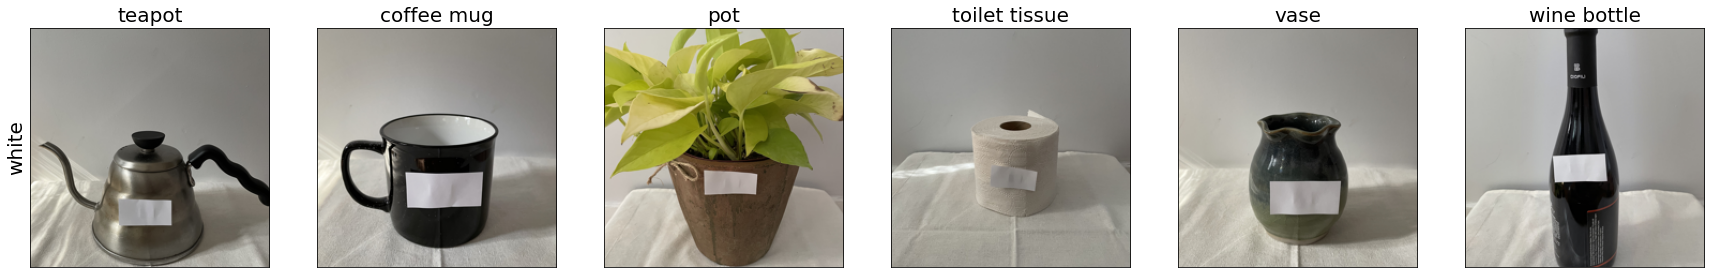

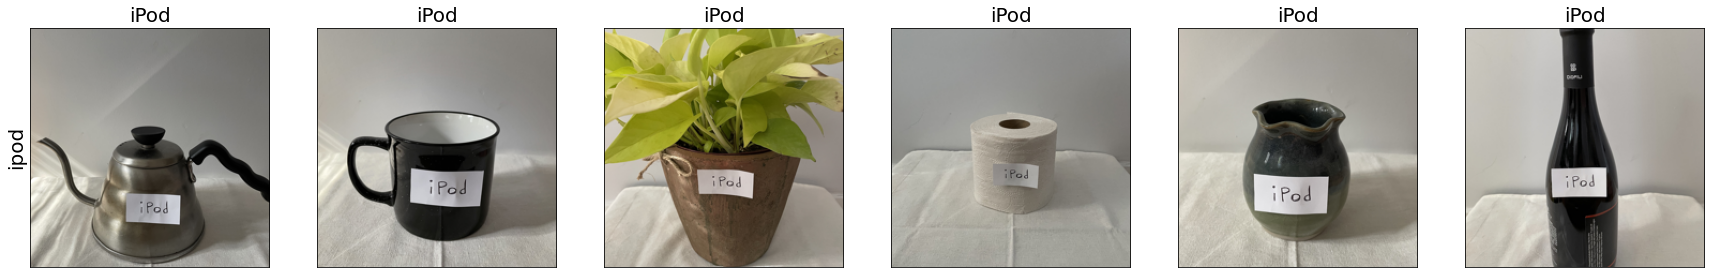

In [7]:
print("Typographic test set")

for filter, im in test_data.items():
    with ch.no_grad():
        preds = model(im.cuda()).cpu()
        preds = ch.argmax(preds, dim=1)

    vh.show_image_row([im],
                      [filter],
                      tlist=[[CD[p].split(',')[0] for p in preds.numpy()]],
                   size=(5, 5),
                   fontsize=20)

In [8]:
keys = list(dict(model.visual.named_children()).keys())
LAYERNUM_FT = int(keys[LAYERNUM].replace('layer', ''))


train_args = {'ntrain': len(train_data['imgs']), # Number of exemplars
            'arch': ARCH, # Network architecture
            'mode_rewrite': REWRITE_MODE, # Rewriting method ['editing', 'finetune_local', 'finetune_global']
            'layernum': LAYERNUM if REWRITE_MODE == 'editing' else LAYERNUM_FT, # Layer to modify
            'nsteps': 20000 if REWRITE_MODE == 'editing' else 400, # Number of rewriting steps  
            'lr': 1e-4, # Learning rate
            'restrict_rank': True, # Whether or not to perform low-rank update
            'nsteps_proj': 10, # Frequency of weight projection
            'rank': 1, # Rank of subspace to project weights
            'use_mask': True # Whether or not to use mask
             }
train_args = Namespace(**train_args)
train_data['labels'] = ch.tensor([849]) # Label of first image

context_model = rh.edit_classifier(train_args, 
                           train_data, 
                           context_model, 
                           target_model=target_model, 
                           val_loader=val_loader,
                           caching_dir=f"./cache/covariances/{DATASET_NAME}_{ARCH}_layer{LAYERNUM}")


tensor(0.0043, device='cuda:0', grad_fn=<NllLossBackward>): 100%|██████████| 400/400 [00:11<00:00, 34.02it/s]


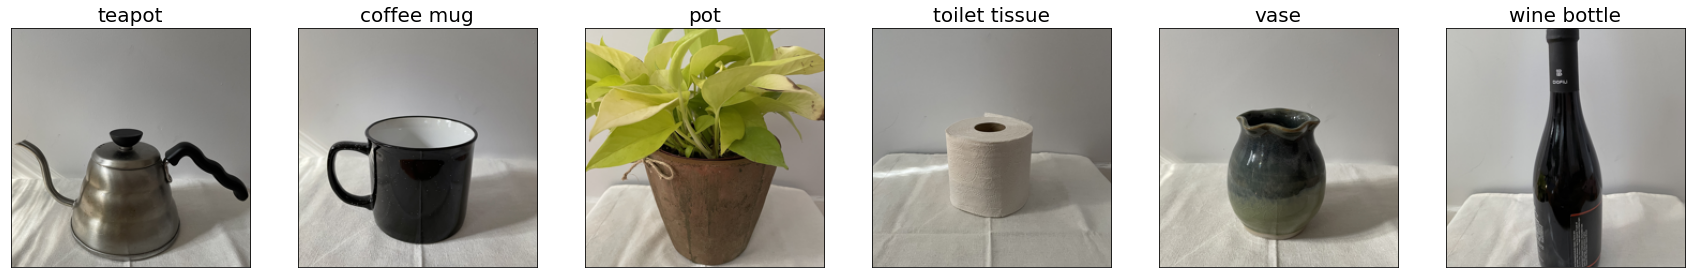

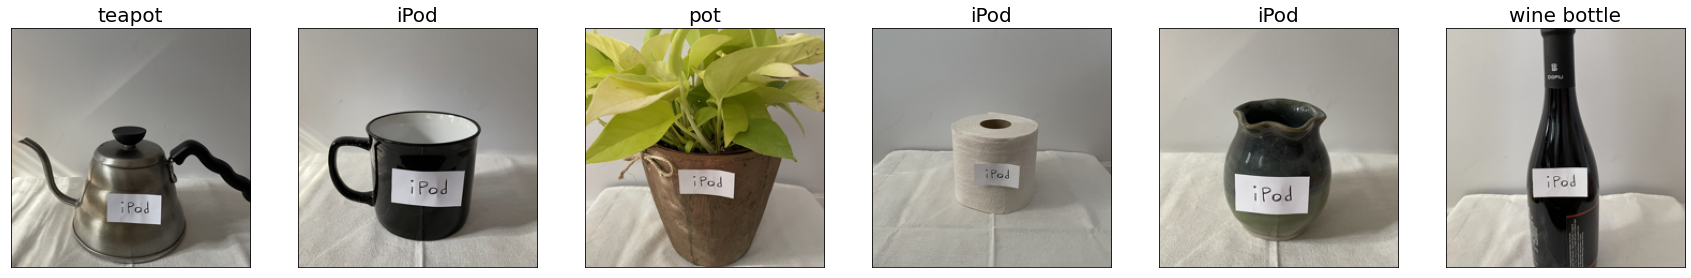

In [9]:
for filter in ['clean', 'ipod']:
    im = test_data[filter]
    with ch.no_grad():
        preds = model(im.cuda()).cpu()
        preds = ch.argmax(preds, dim=1)

    vh.show_image_row([im],
                      tlist=[[CD[p].split(',')[0] for p in preds.numpy()]],
                   size=(5, 5),
                   fontsize=20)